In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat


# Рекомендаційні системи

Необхідно реалізувати алгоритм навчання колаборативної фільтрації та застосувати його до набору даних з рейтингами фільмів ([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) від GroupLens Research). 

In [3]:
def loadMovieList(movie_list):
    """
    Reads the fixed movie list in movie_ids.txt and returns a list of movie names.
    Returns
    -------
    movieNames : list
        A list of strings, representing all movie names.
    """
    # Read the fixed movieulary list
    with open(movie_list,  encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames


У наступних частинах цієї вправи ви реалізуєте функцію `cofiCostFunc`, яка обчислює цільову функцію та градієнт спільної фільтрації. Після обчислення цільової функції та градієнта ви скористаєтеся командою `scipy.optimize.minimize` для визначення параметрів спільної фільтрації.


In [4]:
from scipy.optimize import minimize


## 2.1 Набір даних про рейтинги фільмів

Набір даних складається з оцінок за шкалою від 1 до 5. Набір даних містить $n_u = 943$ користувачів і $n_m = 1682$ фільмів.


Наступна комірка завантажує та відображає перелік назв фільмів та їх порядкові номери.

In [5]:
# Names is list of 1682 strings. Each string is movie name.
names = loadMovieList('movie_ids.txt')
names_df = pd.DataFrame(names).rename(lambda x: 'Movie name',
                                      axis=1).rename_axis('Movie Number')
names_df


,Movie name
Movie Number,
0,Toy Story (1995)
1,GoldenEye (1995)
2,Four Rooms (1995)
3,Get Shorty (1995)
4,Copycat (1995)
...,...
1677,Mat' i syn (1997)
1678,B. Monkey (1998)
1679,Sliding Doors (1998)


Наступна комірка завантажує набір даних `movies.mat`, що містить змінні `Y` та `R`. Матриця `Y` (матриця `num_movies` $\times$ `num_users`) зберігає рейтинги $y^{(i,j)}$ (від 1 до 5). Матриця `R` є двійковою матрицею показників, де $R(i, j) = 1$, якщо користувач $j$ поставив оцінку фільму $i$, і $R(i, j) = 0$ в іншому випадку. 


In [6]:
# Load data
data = loadmat('movies.mat')

# Y is a 1682x943 matrix, containing ratings (1-5) of
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1
# if and only if user j gave a rating to movie i

Y, R = data['Y'], data['R']


Для прикладу продемонструю вигляд матриць $Y$ та $R$ зменшивши їх розмірність до $5\times 5$

In [7]:
pd.DataFrame(Y).head().iloc[:, 0:5].rename(
    lambda x: f'movie_{x}', axis=0).rename(lambda x: f'user_{x}', axis=1)


,user_0,user_1,user_2,user_3,user_4
movie_0,5,4,0,0,4
movie_1,3,0,0,0,3
movie_2,4,0,0,0,0
movie_3,3,0,0,0,0
movie_4,3,0,0,0,0


In [8]:
pd.DataFrame(R).head().iloc[:, 0:5].rename(
    lambda x: f'movie_{x}', axis=0).rename(lambda x: f'user_{x}', axis=1)


,user_0,user_1,user_2,user_3,user_4
movie_0,1,1,0,0,1
movie_1,1,0,0,0,1
movie_2,1,0,0,0,0
movie_3,1,0,0,0,0
movie_4,1,0,0,0,0


Наступна комірка обчислить середній рейтинг середній рейтинг кожного фільму. Фільми, які не були оцінені користувачем, не вносять вклад в розрахунок середньої величини.


In [9]:
# From the matrix, we can compute statistics like average rating.

num_movies, num_users = Y.shape

avg_ratings = np.zeros(num_movies)

for movie_number in range(num_movies):
    binary_mask = R[movie_number]
    row_selected_elements = Y[movie_number][binary_mask]
    avg_ratings[movie_number] = np.mean(row_selected_elements).round(1)

movie_avg_rating_df = pd.DataFrame(avg_ratings).rename(lambda x: f'avg_rating',
                                                       axis=1).rename_axis('Movie Number')

pd.concat([names_df, movie_avg_rating_df], axis=1)


,Movie name,avg_rating
Movie Number,,
0,Toy Story (1995),4.5
1,GoldenEye (1995),2.6
2,Four Rooms (1995),3.6
3,Get Shorty (1995),2.3
4,Copycat (1995),2.7
...,...,...
1677,Mat' i syn (1997),0.0
1678,B. Monkey (1998),0.0
1679,Sliding Doors (1998),0.0


Візуалізуємо в наступній комірці залежність середнього рейтинку від номера фільму та теплову карту для оцінок користувачів.

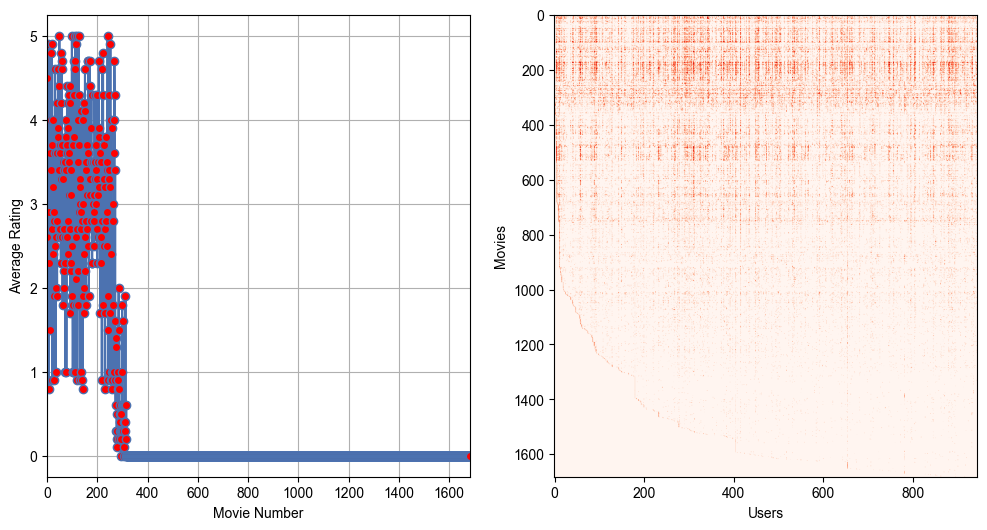

In [10]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Встановлення стилю Seaborn
sns.set(style="whitegrid")

# Перший графік (ax1)
ax1.plot(avg_ratings, '-ob', markerfacecolor='red')
ax1.set_ylabel('Average Rating')
ax1.set_xlabel('Movie Number')
ax1.set_xlim(0, num_movies)

# Другий графік (ax2)
ax2.imshow(Y, cmap='Reds', aspect='auto')
ax2.set_ylabel('Movies')
ax2.set_xlabel('Users')

ax1.grid(True)
ax2.grid(False)
plt.show()


## 2.2. Матриці ознак фізьмів та параметирів користувачів

### Матриця X (Movie Features):

$$ \mathbf{X} =
\begin{bmatrix}
\mathbf{x}^{(1)} \\
\mathbf{x}^{(2)} \\
\vdots \\
\mathbf{x}^{(n_m)}
\end{bmatrix}
=
\begin{bmatrix}
x^{(1)}_{1} & x^{(1)}_{2} & \ldots & x^{(1)}_{10} \\
x^{(2)}_{1} & x^{(2)}_{2} & \ldots & x^{(2)}_{10} \\
\vdots & \vdots & \ddots & \vdots \\
x^{(n_m)}_{1} & x^{(n_m)}_{2} & \ldots & x^{(n_m)}_{10}
\end{bmatrix}
$$

Кожен $i$-й рядок матриці $\mathbf X$ ($\mathbf{x}^{(i)}$) відповідає конкретному фільму ($i$-му фільму).
Кожна компонента вектора $\mathbf{x}^{(i)}$ ($x^{(i)}_1, x^{(i)}_2, \ldots, x^{(i)}_{10}$) представляє собою числові ознаки або характеристики, які описують цей фільм.
Ці ознаки можуть включати інформацію про жанр фільму, акторів, режисера, рік випуску, та інші характеристики фільму.

### Матриця W (User Parameters):

$$
\mathbf{W} =
\begin{bmatrix}
\mathbf{w}^{(1)} \\
\mathbf{w}^{(2)} \\
\vdots \\
\mathbf{w}^{(n_u)}
\end{bmatrix}
=
\begin{bmatrix}
w^{(1)}_{1} & w^{(1)}_{2} & \ldots & w^{(1)}_{10} \\
w^{(2)}_{1} & w^{(2)}_{2} & \ldots & w^{(2)}_{10} \\
\vdots & \vdots & \ddots & \vdots \\
w^{(n_u)}_{1} & w^{(n_u)}_{2} & \ldots & w^{(n_u)}_{10}
\end{bmatrix}.
$$

Кожен $j$-й рядок матриці $\mathbf W$ ($\mathbf{w}^{(j)}$) відповідає конкретному користувачеві ($j$-му користувачеві).
Кожна компонента вектора $\mathbf{w}^{(j)}$ ($w^{(j)}_1, w^{(j)}_2, \ldots, w^{(j)}_{10}$) представляє параметри, які описують схильність цього користувача до певних ознак фільмів.
Ці параметри можуть вказувати на користувачеві вподобання стосовно жанрів, акторів, режисерів, інших користувачів тощо.

---

Для цілей цієї вправи ви будете використовувати $n = 10$, а отже, $x^{(i)} \in \mathbb{R}^{10}$ і $w^{(j)} \in \mathbb{R}^{10}$. Відповідно, `X` - це матриця розміром $n_m \times 10$, а `W` - матриця розміром $n_u \times 10$.

---


## 2.3 Алгоритм навчання колаборативної фільтрації

Мета колаборативної фільтрації полягає в тому, щоб передбачити рейтинги фільмів, які користувачі ще не оцінили, тобто елементів з $R(i, j) = 0$. Це дозволить нам рекомендувати користувачеві фільми з найвищими прогнозованими оцінками.


### 2.3.1 Функція $J$ (`cofiCostFunc`) без регуляризації

Алгоритм колаборативної фільтрації для рекомендацій фільмів розглядає набір n-вимірних векторів параметрів $x^{(1)}, \dots, x^{(n_m)}$ і $w^{(1)} , \dots, w^{(n_u)}$, де модель передбачає оцінку фільму $i$ користувачем $j$ в лінійному вигляді: 

$$
    y^{(i,j)} = \left( w^{(j)} \right)^T x^{(i)}.
$$ 

Маючи набір даних, який складається з набору оцінок, виставлених деякими користувачами деяким фільмам, необхідно дізнатися вектори $x^{(1)}, \dots, x^{(n_m)}, w^{(1)}, \dots, w^{(n_u)}$, які дають найкращу відповідність (мінімізують квадратичну похибку):

$$
J(x^{(1)}, \dots, x^{(n_m)}, w^{(1)}, \dots, w^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left[ \left(w^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right]^2
$$

$J$ - називається функцією втрат колаборативної фільтрації (без регуляризації).


### 2.3.2 Градієнти $(\vec{\nabla}_X J, \vec{\nabla}_W J)$

Градієнти функції вартості задано формулою:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left[ \left(w^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right] w_k^{(j)} $$

$$ \frac{\partial J}{\partial w_k^{(j)}} = \sum_{i:r(i,j)=1} \left[ \left(w^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right] x_k^{(j)} $$


### 2.3.3 Регуляризована функція $J$

Функція витрат для колаборативної фільтрації з регуляризацією має вигляд

$$ J(x^{(1)}, \dots, x^{(n_m)}, w^{(1)}, \dots, w^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( w^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( w_k^{(j)} \right)^2 \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$


### 2.3.4 Регулярнизований градієнт

Градієнти для регуляризованої функції витрат задаються так:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) w_k^{(j)} + \lambda x_k^{(i)} $$

$$ \frac{\partial J}{\partial w_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(w^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda w_k^{(j)} $$


### 2.3.5. Реалізація функції `cofiCostFunc`

Необхідно використовувати векторну реалізацію для обчислення $J$, оскільки пізніше вона буде багато разів викликатися пакетом оптимізації `scipy`. Для створення векторизованої реалізації може бути корисною наступна підказка: Ви можете використовувати матрицю $R$ для встановлення вибраних елементів в 0. Наприклад, `R * M` виконає поелементне множення між `M` і `R`; оскільки `R` має лише елементи зі значеннями 0 або 1, це призведе до встановлення елементів M у 0 лише тоді, коли відповідне значення у R дорівнює 0. Отже, `np.sum( R * M)` - це сума всіх елементів `M`, для яких відповідний елемент у `R` дорівнює 1.

Слід доповнити код у `cofiCostFunc` для повернення змінних `X_grad` та `W_grad`. Зверніть увагу, що `X_grad` має бути матрицею того ж розміру, що і `X`, і аналогічно, `W_grad` є матрицею того ж розміру, що і `W`. 


$$ \left(X_{\text{grad}} \left(i, :\right)\right)^T =
\begin{bmatrix}
\frac{\partial J}{\partial x_1^{(i)}} \\
\frac{\partial J}{\partial x_2^{(i)}} \\
\vdots \\
\frac{\partial J}{\partial x_n^{(i)}}
\end{bmatrix} = \quad
\sum_{j:r(i,j)=1} \left[ \left( w^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right] w^{(j)}
$$


In [11]:
def cofiCostFunc(params, Y, R,
                 num_users,
                 num_movies,
                 num_features,
                 lambda_val=0):
    """
    Обчислює J та grad J для задачі колаборативної фільтрації.

    Параметри:
    ----------

    params (numpy.ndarray): 
        Розгорнуті параметри X та W.

    Y (numpy.ndarray): 
        Матриця рейтингів, де Y[i, j] - рейтинг фільму i користувачем j. З формою (num_movies, num_users).

    R (numpy.ndarray): 
        Матриця бінарних значень, де R[i, j] = 1, якщо фільм i був оцінений користувачем j, і 0 в іншому випадку. З формою (num_movies, num_users).

    num_users (int): 
        Кількість користувачів.

    num_movies (int): 
        Кількість фільмів.

    num_features (int): 
        Кількість ознак для кожного фільму та користувача.

    lambda_val (float): 
        Параметр регуляризації.

    Повертає:
    J (float): 
        Значення вартості для цих параметрів.

    grad (numpy.ndarray): 
        Розгорнутий вектор градієнта відносно параметрів X та W.

    """

    # Розгорнемо параметри
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    W = params[num_movies * num_features:].reshape(num_users, num_features)

    # Обчислимо вартість
    error = (X @ W.T - Y) * R
    J = 1 / 2 * np.sum(error**2)

    # Регуляризаційні члени
    reg_X = 1 / 2 * lambda_val * np.sum(X**2)
    reg_W = 1 / 2 * lambda_val * np.sum(W**2)
    J += reg_X + reg_W

    # Градієнти
    X_grad = (error @ W) + lambda_val * X
    W_grad = (error.T @ X) + lambda_val * W

    # Об'єднаємо градієнти в один вектор
    grad = np.concatenate((X_grad.ravel(), W_grad.ravel()))

    return J, grad


Запустимо перевірку значення градієнта (доступну в `utils.checkCostFunction`), щоб чисельно перевірити реалізацію.

In [12]:
import utils
#  Check gradients by running checkCostFunction
utils.checkCostFunction(cofiCostFunc, 1.5)


[[ 1.40048086  1.40048086]
 [-1.18347842 -1.18347842]
 [ 0.74630779  0.74630779]
 [ 8.79037707  8.79037707]
 [-4.93632654 -4.93632654]
 [-5.93276131 -5.93276131]
 [ 1.41022964  1.41022964]
 [ 1.63326972  1.63326972]
 [-3.02272499 -3.02272499]
 [-0.42031273 -0.42031273]
 [ 3.8441274   3.8441274 ]
 [ 6.02678529  6.02678529]
 [ 1.97115441  1.97115441]
 [-0.55365352 -0.55365352]
 [ 0.45686466  0.45686466]
 [-4.02339197 -4.02339197]
 [ 2.86880129  2.86880129]
 [ 3.21975106  3.21975106]
 [-7.48431101 -7.48431101]
 [ 9.61052449  9.61052449]
 [ 3.40238302  3.40238302]
 [ 1.64540573  1.64540573]
 [-5.7578784  -5.7578784 ]
 [-5.56236611 -5.56236611]
 [ 0.33715865  0.33715865]
 [ 0.81588532  0.81588532]
 [-2.8741396  -2.8741396 ]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1e-9).

Relative Difference: 1.85004e-12



Зауважте, що параметрами функції (тобто значеннями, які ви намагаєтеся дізнатися) є `X` і `W`. Для того, щоб використати готовий мінімізатор, наприклад, функцію `minimize` у `scipy`, функцію вартості було налаштовано на розгортання параметрів у єдиний вектор, який називається `params`. Раніше ви використовували той самий метод розгортання вектора у вправі з програмування нейронних мереж.

## 2.4 Навчання рекомендацій щодо фільмів

Розпочнемо навчання алгоритму для створення рекомендацій щодо фільмів для себе. 

У наступній комірці ви можете ввести власні уподобання щодо фільмів, щоб пізніше, коли алгоритм буде запущено, ви могли отримати власні рекомендації щодо фільмів!

In [13]:
movies_id_list = [0, 97, 6, 11, 53, 63, 65, 68, 182, 225, 354]

for movie in movies_id_list:
    print(names[movie])


Toy Story (1995)
Silence of the Lambs, The (1991)
Twelve Monkeys (1995)
Usual Suspects, The (1995)
Outbreak (1995)
Shawshank Redemption, The (1994)
While You Were Sleeping (1995)
Forrest Gump (1994)
Alien (1979)
Die Hard 2 (1990)
Sphere (1998)


In [14]:
#  Initialize my ratings
my_ratings = np.zeros(len(names))


my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

movie_names = []
ratings = []

for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        movie_names.append(names[i])
        ratings.append(int(my_ratings[i]) * '+')

pd.DataFrame(
    {'ids': movies_id_list, 'Movie Name': movie_names, 'Rating': ratings}).set_index('ids').sort_index()


,Movie Name,Rating
ids,,
0,Toy Story (1995),++++
6,"Usual Suspects, The (1995)",+++++
11,Outbreak (1995),++++
53,"Shawshank Redemption, The (1994)",+++++
63,While You Were Sleeping (1995),+++
65,Forrest Gump (1994),+++++
68,"Silence of the Lambs, The (1991)",++
97,Twelve Monkeys (1995),+++
182,Alien (1979),++++


In [15]:
#  Додамо наші власні рейтинги до матриці даних
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

# Перерахуємо розмір матриць Y та R
num_movies, num_users = Y.shape


### 2.4.1 Рекомендації

Після того, як до набору даних буде додано додаткові рейтинги, скрипт перейде до навчання моделі колаборативної фільтрації. Буде вивчено параметри `X` та `W`. Щоб передбачити рейтинг фільму $i$ для користувача $j$, потрібно обчислити $(w^{(j)})^T x^{(i)}$ . Наступна частина скрипту обчислює рейтинги для всіх фільмів та користувачів і показує фільми, які він рекомендує (Рисунок 4), згідно з рейтингами, які були введені раніше у скрипті. Зауважте, що ви можете отримати інший набір прогнозів через різні випадкові ініціалізації.

In [16]:
#  Нормалізуємо рейтинги
Ynorm, Ymean = utils.normalizeRatings(Y, R)


In [17]:
# Число фіч встановимо 10 оскільки при 100 обробка триває надто довго
num_features = 10

# Регуляризаційний параметр
lambda_val = 10


# Придумуємо рандомні фічі
X = np.random.rand(num_movies, num_features)
W = np.random.rand(num_users, num_features)

initial_params = np.concatenate([X.ravel(), W.ravel()])


In [18]:
% % time

result = minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                         num_movies, num_features, lambda_val),
                  initial_params,
                  method='TNC',
                  jac=True
                  )

# Оптимальні значення параметрів
optimal_params = result.x

# Витягуємо навчені X та W
X = optimal_params[:num_movies *
                   num_features].reshape(num_movies, num_features)
W = optimal_params[num_movies *
                   num_features:].reshape(num_users, num_features)


CPU times: total: 23.2 s
Wall time: 20.9 s


In [19]:
p = X @ W.T
my_predictions = p[:, 0] + Ymean

ix = np.argsort(my_predictions)[::-1]

recommendations = []
for i in range(20):
    j = ix[i]
    movie_name = names[j]
    predicted_rating = my_predictions[j].round(1)
    recommendations.append(
        {'ids': j, 'Movie Name': movie_name, 'Predicted Rating': predicted_rating})

# Створюємо DataFrame
pd.DataFrame(recommendations).set_index('ids').sort_values(
    by='Predicted Rating', ascending=False)


,Movie Name,Predicted Rating
ids,,
1598,Someone Else's America (1995),5.0
1188,Prefontaine (1997),5.0
1121,They Made Me a Criminal (1939),5.0
813,"Great Day in Harlem, A (1994)",5.0
1292,Star Kid (1997),5.0
1466,"Saint of Fort Washington, The (1993)",5.0
1652,Entertaining Angels: The Dorothy Day Story (1996),5.0
1499,Santa with Muscles (1996),5.0
1535,Aiqing wansui (1994),5.0
